#  QUDOS: Quantum Occupation Dynamics Simulation - Multi-Pulse and Multi-Level System Simulation Software

This repository contains simulation codes for the occupation dynamics of a 4-level quantum system. The software is designed to assist researchers and students in the field of quantum optics in gaining a better understanding of the behavior of 4-level quantum systems and various excitation schemes.  

This software was developed by Yusuf Karli (University of Innsbruck, University of Cambridge), Thomas K. Bracht (TU Dortmund), and Doris E. Reiter (TU Dortmund).


**Acknowledgements**  

We would also like to express our gratitude to Florian Kappe, and Gregor Weihs for their invaluable support and contributions to this project, aas well as to the QUTIP project for providing the useful functions upon which our software is built.  

**Contributing**  
We welcome contributions to this project. If you would like to contribute:

- Fork the repository
- Create a new branch for your feature or bug fix
- Commit your changes
- Submit a pull request


**License**

This project is licensed under the Creative Commons Attribution 4.0 International License -  visit [Creative Commons Attribution 4.0 International License](https://creativecommons.org/licenses/by/4.0/).  

To give proper attribution, please cite the original work as follows:  
* QUDOS: Quantum Occupation Dynamics Simulation [2023], [Doi-Number]


**Contact**  
For any questions or concerns, please feel free to contact the project maintainer at yusuf.karli@uibk.ac.at




In [1]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Define a class named Pulse to create laser pulses 
class Pulse:
    def __init__(self, tau, e_start, w_gain=0, t0=0, e0=1, phase=0, polar_x=1):
        self.tau = tau  # in ps (tau is a time constant)
        self.e_start = e_start  # in meV (e_start is the starting energy)
        self.w_start = e_start / HBAR  # in 1 / ps (calculate angular frequency)
        self.w_gain = float(w_gain)  # in 1/ps^2 (rate of change of angular frequency)
        self.t0 = t0  # initial time
        self.e0 = e0  # initial energy
        self.phase = phase  # phase of the pulse
        self.freq = None  # frequency , initialized to None
        self.phase_ = None  # phase_ , initialized to None
        self.polar_x = polar_x  # x-component of polarization
        self.polar_y = np.sqrt(1 - polar_x ** 2)  # calculate y-component of polarization

    def __repr__(self):
        
        return "%s(tau=%r, e_start=%r, w_gain=%r, t0=%r, e0=%r)" % (
            self.__class__.__name__, self.tau, self.e_start, self.w_gain, self.t0, self.e0
        )

    def get_envelope(self, t):
        # Calculate the envelope of the pulse at a given time t
        return self.e0 * np.exp(-0.5 * ((t - self.t0) / self.tau) ** 2) / (np.sqrt(2 * np.pi) * self.tau)
    
    def set_frequency(self, f):
        #Set the time-dependent frequency using a lambda function f that takes time t.
        
        self.freq = f

    def get_frequency(self, t):
        #Calculate the frequency (omega) for a given time t.
        
        if self.freq is not None:
            return self.freq(t)
        return self.w_start + self.w_gain * (t - self.t0)

    def get_full_phase(self, t):
        # Calculate the full phase of the pulse at a given time t
        return self.w_start * (t - self.t0) + 0.5 * self.w_gain * ((t - self.t0) ** 2) + self.phase
    
    def get_energies(self):
        #Get the energy difference of +- tau for a chirped pulse.
        
        low = self.get_frequency(-self.tau)
        high = self.get_frequency(self.tau)
        energy_range = np.abs(high - low) * HBAR  # Calculate energy range in meV
        return energy_range

    def get_total(self, t):
        # Calculate pulse envelope at a given time t
        return self.get_envelope(t) * np.exp(-1j * self.get_full_phase(t))


# Chirping the laser pulses
class ChirpedPulse(Pulse):
    def __init__(self, tau_0, e_start, alpha=0, t0=0, e0=1 * np.pi, polar_x=1):
        self.tau_0 = tau_0  # Initial tau value
        self.alpha = alpha  # Chirp Value
        # Initialize the ChirpedPulse using parameters and super() to call the parent class's constructor
        super().__init__(tau=np.sqrt(alpha**2 / tau_0**2 + tau_0**2), e_start=e_start, w_gain=alpha / (alpha**2 + tau_0**4), t0=t0, e0=e0, polar_x=polar_x)
    
    def get_parameters(self):
        """
        Returns tau and chirp parameter.
        """
        return "tau: {:.4f} ps , a: {:.4f} ps^-2".format(self.tau, self.w_gain)

    def get_envelope(self, t):
        # Calculate the pulse envelope  at a given time t
        return self.e0 * np.exp(-0.5 * ((t - self.t0) / self.tau) ** 2) / (np.sqrt(2 * np.pi * self.tau * self.tau_0))

    def get_ratio(self):
        """
        Returns the ratio of pulse area chirped/unchirped: tau / sqrt(tau * tau_0).
        """
        return np.sqrt(self.tau / self.tau_0)



In [2]:
# Biexciton Function - Run this function
HBAR = 0.6582173  # meV*ps

def energies(delta_b=4., delta_0=0.):
    # energy levels of the system
    E_X = -delta_0/2
    E_Y =  delta_0/2
    return E_X, E_Y,

def two_level_system(collapse= "nodecay", tau1=1, area1=1*np.pi, det1=0, alpha1=0, prob_x=1/2,
    pol1_x=1,  delta_0=0.0, gamma_e=1/100, epsilon=0.01, 
    dt_1=0.1, options=qt.Options(atol=1e-7), mode="population"):
    """
    In qutip, every energy has to be provided in 1/ps
    Here, a rotating frame with the unsplit exciton energy is chosen. 
    collapse: choose "spontane" if you wanna include decay otherwise choose "coherent" to leave collapse operators empty. 
    tau1/2: pulse 1/2 duration in ps
    area1/2: pulsearea of pulse 1/2
    det1/2: detuning of pulse 1/2 to unsplit exciton energy in meV
    alpha1/2: chirp of pulse1/2 in ps^2
    pol1/2_x: x polarization component of pulse 1/2. possible options = 0,...,1
    delay: delay of pulse 2 to pulse 1 in ps
    delta_b: biexciton binding in meV
    delta_0: exciton X/Y splitting in meV (FSS)
    gamma_e: inverse exciton lifetime in 1/ps
    gamma_b: inverse biexciton lifetime in 1/ps
    epsilon: exponential decay, until epsilon is reached
    dt_1: timestep during pulse (0,..,8tau)
    dt_2: timestep after the pulse, during the decay
    mode: "pop" for population. This is for various possible modes in the future. 
    """
    delta_0 = delta_0 / HBAR

    # system states
    g =qt.basis(4,0)
    x = qt.basis(4,1)
    y = qt.basis(4,2)
    
    # Initialize the ground state. For example, if you want to start from the ground state, set prob_x to zero.
    # "prob_x" represents the probability amplitude of the biexciton state. If you want to start with a superposition of the ground state and exciton, then change "np.sqrt(prob_x) * b" to "x" or "y".
    # If you want to have a superposition of the ground state, exciton, and biexciton, then you can change "gxbas" as you wish.
    
    gxbas =np.sqrt(1-prob_x)*g + np.sqrt(prob_x)*x

    # number operators
    n_g = g * g.dag()
    n_x = x * x.dag()
    n_y = y * y.dag()

    # transition operators / polarizations
    p_gx = g * x.dag()
    p_gy = g * y.dag()

    # Check the value of the collapse parameter
    if collapse == "nodecay":
        # Collapse operators (empty for a coherent process)
        c_ops = []

    # Check the value of the collapse parameter
    if collapse == "decay":
        # Define collapse operators for spontaneous emission
        c_ops = [np.sqrt(gamma_e) * p_gx, np.sqrt(gamma_e) * p_gy]

    # system Hamiltonian
    E_X, E_Y = energies( delta_0=delta_0) # note they are already divided by HBAR
    H_sys = E_X * n_x + E_Y * n_y 

    # pulse 1 and 2, right now assume delay > 0
    tau11=np.sqrt(alpha1**2 / tau1**2 + tau1**2)
    # choose the longer of the two
    t_start1 = 4*tau11 #if tau11 > tau22 else 4*tau22
    # further delay pulse 2
    pulse1 = ChirpedPulse(tau1, det1, alpha1, t0=t_start1, e0=area1, polar_x=pol1_x)

    # excitation Hamiltonians (daggered, as expressed by polarization operators)
    H_x_dag = -0.5 * (p_gx)  # this has to be paired with the conjugated total x-field 
    H_y_dag = -0.5 * (p_gy)
    # print(H_x_dag.dag())

    H = [H_sys, [H_x_dag, lambda t,args : np.conj(pulse1.polar_x*pulse1.get_total(t) )],
                [H_y_dag, lambda t,args : np.conj(pulse1.polar_y*pulse1.get_total(t) )],
                [H_x_dag.dag(), lambda t,args : pulse1.polar_x*pulse1.get_total(t) ],
                [H_y_dag.dag(), lambda t,args : pulse1.polar_y*pulse1.get_total(t) ]]
    
    # time axes. has to start at 0 due to limitations in the function calculating the 2-time quantities
    # two different time steps are used: a small dt_1, during the time the pulses are active, and a larger dt_2 during the decay 
    # time axis during the pulses
    t_off =  t_start1  # time window where pulse 1 or 2 is still active
    rate = 2*gamma_e if 2*gamma_e<gamma_e else gamma_e
    t_end = t_off - 1/rate *np.log(epsilon)  # note that log(epsilon) is in general negative
    t_axis1 = np.arange(0, t_off, dt_1)
    t_axis2 = np.arange(t_off, t_end)  # note that arange does not include the final value so t_off is not in both arrays
    t_axis = np.append(t_axis1, t_axis2)

    if mode == "population":
        g_occ, x_occ, y_occ, polar_gx, polar_xb = qt.mesolve(H, gxbas, t_axis, c_ops=c_ops, e_ops=[n_g, n_x, n_y, p_gx,p_gy], options=options).expect
        return g_occ, x_occ, y_occ,  polar_gx, polar_xb, t_axis, #tau1, tau2, area1, area2, det1, det2, alpha1, alpha2, pol1_x, pol2_x, delay, delta_b, delta_0, gamma_e, gamma_b


c:\Users\yusuf\AppData\Local\Programs\Python\Python313\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


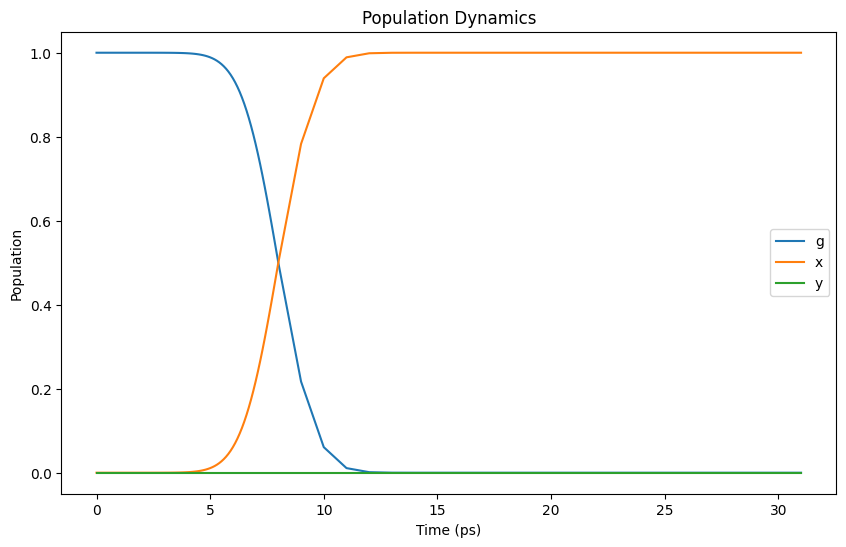

In [5]:
gamma_e=1/5
g, x,y,gx,xb,t = two_level_system(collapse="nodecay", tau1=2, dt_1=0.1, prob_x=0,
            gamma_e=gamma_e, 
            area1=1*np.pi, alpha1=0, det1=0, pol1_x=np.sqrt(1), 
            mode="population"
            ) 

plt.figure(figsize=(10, 6))
plt.plot(t, g, label='g')
plt.plot(t, x, label='x')
plt.plot(t, y, label='y')
plt.xlabel('Time (ps)')
plt.ylabel('Population')
plt.legend()
plt.title('Population Dynamics')
plt.show()

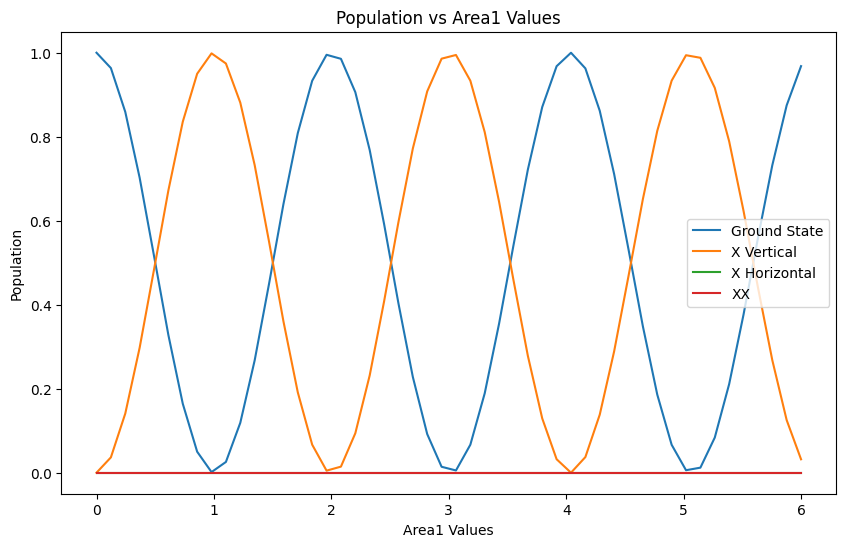

In [ ]:
# Define ranges for area1 and det1 parameters
area1_values = np.linspace(0, 6, 50)  # Adjust the range and number of points as needed
det1= 0

# Initialize 2D array to store maximum b values and 3D arrays for g, x, y, and b
b_pop = np.zeros(len(area1_values))
g_pop, x_pop, y_pop = np.zeros(len(area1_values)), np.zeros(len(area1_values)), np.zeros(len(area1_values))

g_values, x_values, y_values, b_values = ([] for i in range(4)) 

# Iterate through area1 and det1 values
for i, area1 in enumerate(area1_values):
        gamma_e=1; gamma_b=1 ; 
        g, x,y,b,gx,xb,gb,t = two_level_system(collapse="nodecay", tau1=2, dt_1=0.1,dt_2=0.01, prob_x=0,
                    gamma_b=gamma_b, gamma_e=gamma_e, delta_b=4,
                    area1=area1*np.pi, alpha1=0, det1=det1, pol1_x=1, pol2_x=np.sqrt(1), 
                    tau2=3 ,alpha2=0, area2=0*np.pi, det2=-4, delay=10, mode="population"
                    ) 
        
        b_pop[i] = b[-1]  # Store the maximum b value for this combination of area1 and det1
        g_pop[i], x_pop[i], y_pop[i] = g[-1], x[-1], y[-1]

        g_values, x_values, y_values, b_values = g, x, y, b  # Store the function outputs



plt.figure(figsize=(10, 6))
plt.plot(area1_values, g_pop, label='Ground State')
plt.plot(area1_values, x_pop, label='X Vertical')
plt.plot(area1_values, y_pop, label='X Horizontal')
plt.plot(area1_values, b_pop, label='XX')
plt.xlabel('Pulse Area')
plt.ylabel('Population')
plt.legend()
plt.title('Population vs Area1 Values')
plt.show()